# pixel-shuffle

In [1]:
# pixel-shuffle lets you rearrange the pixels of one image to create another image
# Copyright (C) 2021  Rishi Advani

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

## setup

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy
from scipy import optimize
import numpy as np
from tqdm.notebook import trange, tqdm

In [3]:
rng = np.random.default_rng()

In [4]:
skeleton_filename = "woman.jpg"
filler_filename = "chameleon.jpg"

In [5]:
skel_img = Image.open("input/" + skeleton_filename)
fill_img = Image.open("input/" + filler_filename)

In [6]:
dims = skel_img.size
fill_img = fill_img.resize(dims)

In [7]:
skel_arr = np.asarray(skel_img)
fill_arr = np.asarray(fill_img)

In [8]:
rows, cols, _ = skel_arr.shape

## generate pixel shuffle

In [9]:
precision = 5000  # default to 5000

In [10]:
total_pixels = skel_arr.size

import math
O = int(math.sqrt(total_pixels / precision))

In [11]:
r = rows // O
c = cols // O
        
cost_matrix = np.empty((r,c,r,c))

In [12]:
for i in trange(r):
    for j in trange(c, leave=False):
        avg_skel = np.average(skel_arr[i*O:i*O+O, j*O:j*O+O], axis=(0,1))
        for i2 in range(r):
            for j2 in range(c):
                avg_fill = np.average(fill_arr[i2*O:i2*O+O, j2*O:j2*O+O], axis=(0,1))
                cost_matrix[i,j,i2,j2] = np.linalg.norm(avg_fill - avg_skel)


temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
_, col_ind = optimize.linear_sum_assignment(temp)

coords = col_ind.reshape(r,c)

In [28]:
final_arr = np.full((rows, cols, 3), 255, dtype=int)

for i in range(r):
    for j in range(c):
        temp = coords[i,j]
        i2 = temp // c
        j2 = temp % c
        
        final_arr[i*O:i*O+O, j*O:j*O+O] = fill_arr[i2*O:i2*O+O, j2*O:j2*O+O].copy()

### set up interpolation

In [29]:
interp_mode = "fixed"  # default to "fixed"

In [30]:
if interp_mode == "prop" or interp_mode == "dissolve":
    interp_coef = 50
    interp_arrs = np.full((interp_coef, rows, cols, 3), 255, dtype=int)
    interp_domain = np.linspace(0, 1, num=interp_coef)

    for k, val in enumerate(tqdm(interp_domain)):
        for i in range(r):
            for j in range(c):
                temp = coords[i,j]
                i2 = temp // c
                j2 = temp % c

                if interp_mode == "prop":
                    i3 = int(i * (val) + i2 * (1-val))
                    j3 = int(j * (val) + j2 * (1-val))
                    interp_arrs[k, i3*O:i3*O+O, j3*O:j3*O+O] = fill_arr[i2*O:i2*O+O, j2*O:j2*O+O].copy()

                elif interp_mode == "dissolve":
                    i3 = int(i * (1 - val) + i2 * val)
                    j3 = int(j * (1 - val) + j2 * val)
                    interp_arrs[k, i*O:i*O+O, j*O:j*O+O] = fill_arr[i3*O:i3*O+O, j3*O:j3*O+O].copy()

In [31]:
if interp_mode == "fixed":
    interp_coef = 0
    interp_arrs = []
    
    curr_locs = np.zeros((r, c), dtype=int)
    for i in range(r):
        for j in range(c):
            curr_locs[i,j] = coords[i,j]
    
    flag = True
    while flag:
        flag = False
        
        arr = np.full((rows, cols, 3), 255, dtype=int)
        
        occupied = np.zeros((r, c), dtype=bool)
        
        for i in range(r):
            for j in range(c):
                temp = coords[i,j]
                i4 = temp // c
                j4 = temp % c
                
                temp = curr_locs[i,j]
                i2 = temp // c
                j2 = temp % c
                
                # record old position
                i3 = i2
                j3 = j2
                
                # move towards target
                if i < i2:
                    i2 -= 1
                elif i > i2:
                    i2 += 1
                if j < j2:
                    j2 -= 1
                elif j > j2:
                    j2 += 1
                
                if (i2 != i) or (j2 != j):  # not all pixels have reached target
                    flag = True
                
                curr_locs[i,j] = i2 * c + j2
                occupied[i2,j2] = True
                
                arr[i2*O:i2*O+O, j2*O:j2*O+O] = fill_arr[i4*O:i4*O+O, j4*O:j4*O+O].copy()
                
                if not occupied[i3,j3]:
                    arr[i3*O:i3*O+O, j3*O:j3*O+O] = 255
        
        interp_arrs.append(arr)
        interp_coef += 1

## display results

In [32]:
# %matplotlib inline
# plt.imshow(skel_arr);

In [33]:
# %matplotlib inline
# plt.imshow(fill_arr);

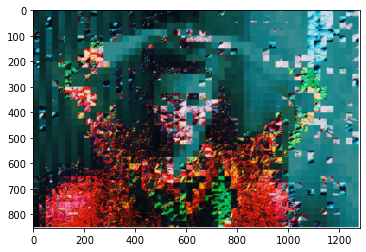

In [34]:
%matplotlib inline
plt.imshow(final_arr);

In [35]:
%matplotlib notebook
fig = plt.figure()

ims = []

# start delay
for _ in range(20):
    im = plt.imshow(fill_arr, animated=True)
    ims.append([im])

# core animation
for k in range(interp_coef):
    im = plt.imshow(interp_arrs[k], animated=True)
    ims.append([im])

# end delay
for _ in range(20):
    im = plt.imshow(final_arr, animated=True)
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=30, repeat_delay=10, blit=True)

plt.axis("off")

plt.show()

<IPython.core.display.Javascript object>

In [36]:
from datetime import datetime

datetime_obj = datetime.now()
timestamp = datetime_obj.strftime("%Y-%m-%d_%H-%M-%S")
output_filename = "output/pixel-shuffle_" + timestamp + ".gif"

ani.save(output_filename, writer="pillow")